## 0. Computer vision libaries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## 1. Getting a dataset

The dataset we will be using is FashionMNIST from `torchvision.datasets`

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root='data', # Where to download data to
    train=True, # Do we want the training dataset? If set 'False' we will get back test dataset instead
    download=True, # Do we want to download yes/no
    transform=ToTensor(), # how do we want to transform the data
    target_transform=None # how do we want to transform the labels/targets
    )

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
    )

100%|██████████| 26421880/26421880 [00:01<00:00, 17481962.90it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 306554.25it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5572392.06it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14738755.63it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
image, label = train_data[0]
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {train_data.classes[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

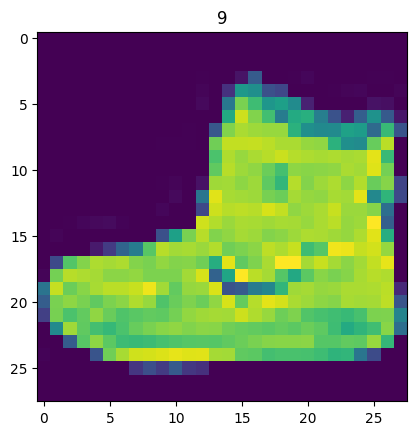

In [ ]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

(-0.5, 27.5, 27.5, -0.5)

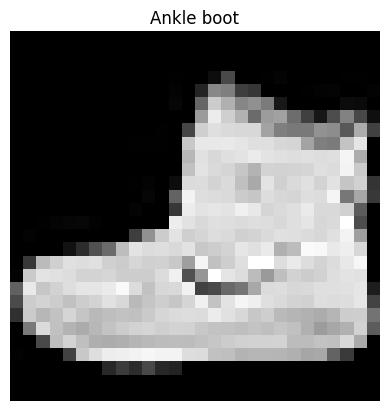

In [ ]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(train_data.classes[label])
plt.axis(False)

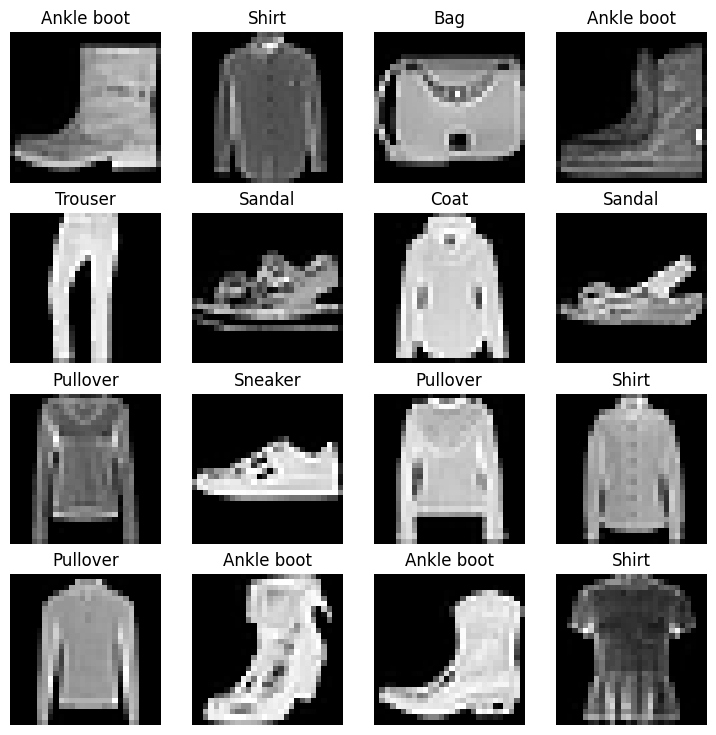

In [ ]:
# Plot more images
torch.manual_seed(42)
torch.cuda.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train_data.classes[label])
  plt.axis(False)

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets

DataLoader turns our dataset into a Python iterable

More specifically, we want to turn our data into batches (or mini-batches)

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit, so we break it down to 32 images at a time (batch size of 32)
2. It gives our neural network more chances to update its gradients per epoch

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))  # we getting the next batch with 'next', and we turn it into iterable with 'iter'
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

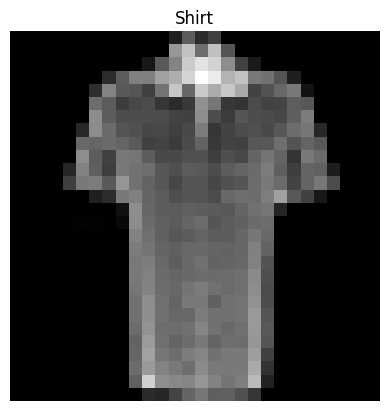

In [ ]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(train_data.classes[label])
plt.axis(False)


## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it is best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [ ]:
from torch.nn.modules.linear import Linear
from matplotlib.colors import Sequence
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))

model_0.to('cpu')


FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we are working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimzer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we are working on a classification problem, let's use accruacy as our evaluation metric

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exist, skipping')
else:
  print('Downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental

Two of the main things you will often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out what's happening
5. Time it all

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")
  # Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (x, y) in enumerate(train_dataloader):
    model_0.train()
    # Forward pass
    y_pred = model_0(x)

    # Calculate the loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(x)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing loop
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for x, y in test_dataloader:  # x -> image, y -> label for each class
      # Forward pass
      test_pred = model_0(x)

      # Calculate the loss
      test_loss += loss_fn(test_pred, y)

      # Calculate the accuracy
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  # Calculate training time
  train_time_end_on_cpu = timer()
  total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.0387
Train time on cpu: 11.438 seconds
Epoch: 1

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.1969
Train time on cpu: 22.955 seconds
Epoch: 2

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.4265
Train time on cpu: 34.081 seconds


## 4. Make predictions and get Model 0 results

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  """Returns a dict containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x, y in tqdm(data_loader):
      # Make predictions
      y_pred = model(x)

      # Accumulate the loss and acc values
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {'model_name': model.__class__.__name__, # only works when model was created with a class
            'model_loss': loss.item(),
            'model_acc': acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [ ]:
# Setup device-agnostic code
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 6. Model 1: Building a better model with non-linearity



In [ ]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
# Create an instance of model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cpu')

### 6.1 Setup loss, optimizer, and evaluation metrics

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops

Create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader"""

  train_loss, train_acc = 0, 0

  #Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (x, y) in enumerate(data_loader):
    # Put data on target device
    x, y = x.to(device), y.to(device)

    # Forward pass
    y_pred = model(x)

    # Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader"""

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x, y in data_loader:  # x -> image, y -> label for each class
      x, y = x.to(device), y.to(device)

      # Forward pass
      test_pred = model(x)

      # Calculate the loss
      test_loss += loss_fn(test_pred, y)

      # Calculate the accuracy
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(data_loader)

    # Calculate the test acc average per batch
    test_acc /= len(data_loader)

  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device
            )
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
            )
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1

Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2

Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%

Train time on cpu: 35.933 seconds


In [ ]:
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  """Returns a dict containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x, y in tqdm(data_loader):
      # Put data on target device
      x, y = x.to(device), y.to(device)

      # Make predictions
      y_pred = model(x)

      # Accumulate the loss and acc values
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {'model_name': model.__class__.__name__, # only works when model was created with a class
            'model_loss': loss.item(),
            'model_acc': acc}

In [ ]:
# Get model_1 results dict
model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

model_1_results


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850009560585022,
 'model_acc': 75.01996805111821}

## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets

CNN's are known for their capabilities to find patterns in visual data

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # there is a trick to calculating this.....
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # input_shape=1 because we only have 1 color channel as gray, if our images are colored, input_shape would be 3
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [ ]:
model_2(image.unsqueeze(0).to(device))

tensor([[ 0.0300, -0.0610,  0.0485, -0.0278, -0.0125,  0.0172, -0.0056, -0.0121,
          0.0243,  0.0095]], grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d()`

In [ ]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

In [ ]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)

# Pass the data through convolutional layer
conv_output = conv_layer(test_image)

### 7.2 Stepping through `nn.MaxPool2d()`

In [ ]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image)
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_maxpool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_maxpool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([10, 31, 31])


In [ ]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"\nRandom tensor:\n {random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for `model_2`

In [ ]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

### 7.4 Training and testing `model_2` using our training and test functions

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")

  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.59518 | Train acc: 78.38%
Test loss: 0.39500 | Test acc: 85.99%

Epoch: 1
Train loss: 0.36536 | Train acc: 86.90%
Test loss: 0.35244 | Test acc: 86.91%

Epoch: 2
Train loss: 0.32588 | Train acc: 88.13%
Test loss: 0.32719 | Test acc: 88.07%

Train time on cpu: 178.093 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

## 8. Compare model results and training time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                               model_1_results,
                               model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.327190,88.069089


In [ ]:
# Add training time to results comparison
compare_results['training_time'] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,34.080530
1,FashionMNISTModelV1,0.685001,75.019968,35.932569
2,FashionMNISTModelV2,0.327190,88.069089,178.093178


Text(0, 0.5, 'model')

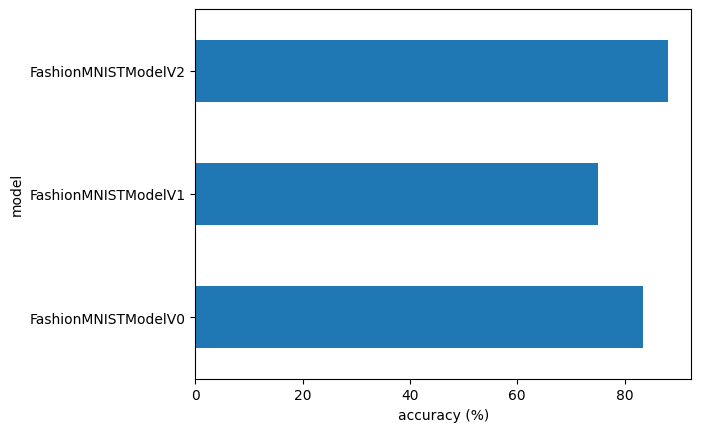

In [ ]:
# Visualize our model results
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model')

## Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device) # sample is going to be a single image, and we 'unsqueeze' it to add batch size dimension

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)  # concatenate everything in the list to a single tensor


In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model_2, data=test_samples)

# View first two prediction probabilities
pred_probs[:2]


tensor([[1.4021e-06, 1.7343e-07, 4.4511e-07, 1.2103e-05, 5.4026e-07, 9.9938e-01,
         3.7154e-06, 2.1650e-04, 1.4199e-04, 2.4416e-04],
        [1.0080e-01, 5.6287e-01, 7.4506e-04, 1.1212e-01, 6.3881e-02, 3.0674e-04,
         1.5560e-01, 1.6463e-03, 1.0169e-03, 1.0133e-03]])

In [ ]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

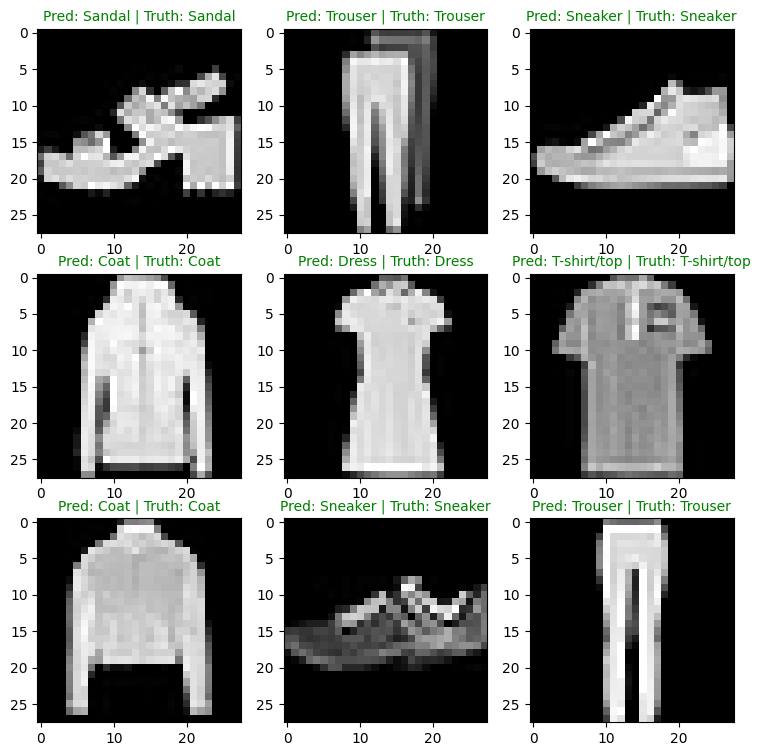

In [ ]:
# Plot prediction
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap='gray')

  # Find the prediction (in text form, e.g 'Sandal')
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form )
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c='g') # green text if labels match
  else:
    plt.title(title_text, fontsize=10, c='r')

## Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your classification models visually

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
# Import tqdm.auto
from tqdm.auto import tqdm


# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for x, y in tqdm(test_dataloader, desc='Making predictions...'):
    # Send the data and targets to target device
    x, y = x.to(device), y.to(device)
    # forward pass
    y_logits = model_2(x)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())


# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split('.')[1]) >= 19, 'mlxtend version should be 0.19.0 or higher'
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [ ]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [ ]:
y_pred_tensor

tensor([9, 2, 1,  ..., 8, 1, 8])

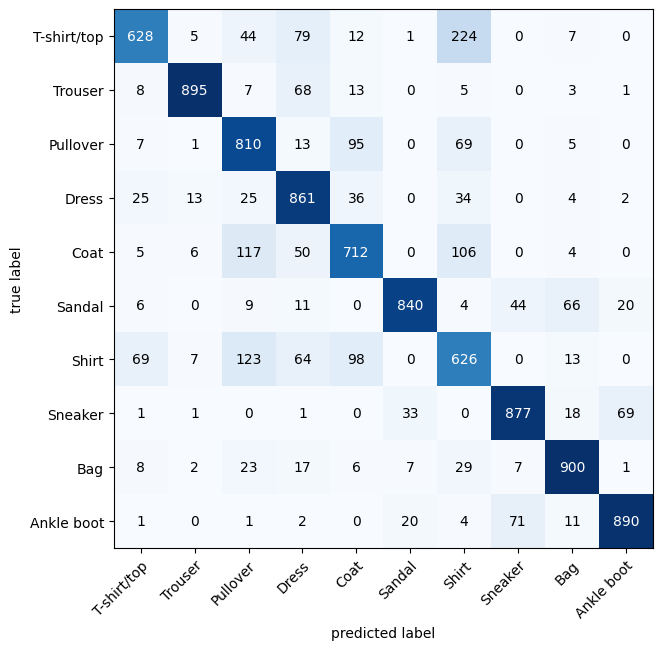

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib works with numpy
                                class_names=class_names,
                                figsize=(10, 7)
                                )


## 11. Save and load best performing model

In [ ]:
from pathlib import Path

# Create model directory path
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)

# Create model save path
model_name = 'pytorch_computer_vision_model_2.pth'
model_save_path = model_path / model_name

# Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model_2.state_dict(), f=model_save_path)


Saving model to: models/pytorch_computer_vision_model_2.pth


In [ ]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=model_save_path))

# Send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

In [ ]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results['model_loss']),
              torch.tensor(loaded_model_2_results['model_loss']))

tensor(True)